# SFH Assuming some binaries for LMC

In [1]:

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astroquery.vizier import Vizier
from astropy.coordinates import SkyCoord
data_dir = os.getenv("DATADIR")
vizier = Vizier()
vizier.ROW_LIMIT = -1

table_name = 'J/MNRAS/508/245' # Mazzi 2021
# a1-a5: Best fit SFR at log(age/yr)<8.1
# 100 million years = 1e8 years
t = vizier.get_catalogs(table_name)

data = t[0].to_pandas()
coords = SkyCoord(ra=data['RAJ2000'], dec=data['DEJ2000'], unit='deg')
sums = pd.read_csv(f"{data_dir}/0_SUMS_Catalogs/FinalCatalogs/SUMS_UV_Catalog.csv")
sums_cos = SkyCoord(ra=sums['RA'], dec=sums['Dec'], unit='deg')

# It overlaps with the SUMS catalog if the distance to the nearest source is less than 5 arcmin
for i, co in enumerate(coords):
    idx, d2d, d3d = co.match_to_catalog_sky(sums_cos)
    if d2d.arcmin < 5.0:
        data.loc[i, 'IN_SUMS'] = 1
    else:
        data.loc[i, 'IN_SUMS'] = 0

#insums = data[data['IN_SUMS'] == 1].reset_index(drop=True)

# Add together all values in columns a1 to a5
young_sfr_cols = ['a1', 'a2', 'a3', 'a4', 'a5']
data['Young_SFR'] = data[young_sfr_cols].sum(axis=1)

# Sum the SFR values for each row
young_in_sums = data.loc[data['IN_SUMS'] == 1, 'Young_SFR'].sum()
young_everywhere = data['Young_SFR'].sum()

vmc_fraction = young_in_sums / young_everywhere
print(f"{vmc_fraction * 100:.2f}% of the total SFR <100Myr in the Mazzi 2021 catalog is in the SUMS catalog.")

sfr_DennisZaritsky = .4
difference = sfr_DennisZaritsky - vmc_fraction
print(f"Difference in SFR <100Myr between Mazzi 2021 and Dennis & Zaritsky: {difference*100:.2f} (Dennis & Zaritsky - Mazzi)")


53.88% of the total SFR <100Myr in the Mazzi 2021 catalog is in the SUMS catalog.
Difference in SFR <100Myr between Mazzi 2021 and Dennis & Zaritsky: -13.88 (Dennis & Zaritsky - Mazzi)


(-72.0, -67.0)

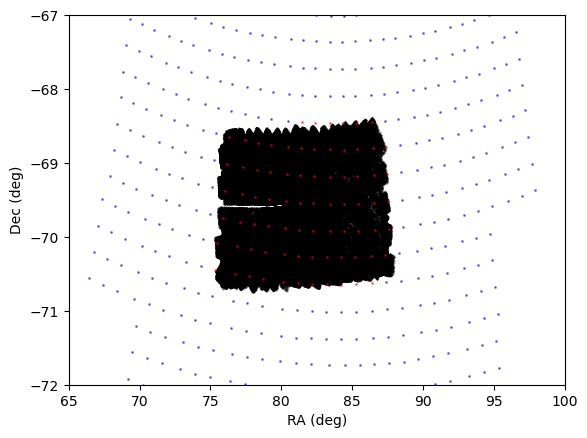

In [2]:
# Check that we are picking the overlapping cells correctly
insums = data[data['IN_SUMS'] == 1].reset_index(drop=True)

plt.scatter(sums['RA'], sums['Dec'], s=0.1, color='k', alpha=0.5, label='SUMS')
plt.scatter(insums['RAJ2000'], insums['DEJ2000'], s=1, color='r', alpha=0.5, label='VMC in SUMS')
out = data[data['IN_SUMS'] == 0]
plt.scatter(out['RAJ2000'], out['DEJ2000'], s=1, color='b', alpha=0.5, label='VMC not in SUMS')
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.xlim(65, 100)
plt.ylim(-72, -67)